In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam



In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.22.210:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.0.22.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.22.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/DACON/North_Pole/'
train_csv = pd.read_csv(path+'train_v2.csv')
train_csv.head()

,month,file_nm
0,1978-11,197811.npy
1,1978-12,197812.npy
2,1979-01,197901.npy
3,1979-02,197902.npy
4,1979-03,197903.npy


In [ ]:
train_path = sorted(glob(path+'train_data_v2/*.npy'))
train_path = train_path[-40*12:]
train = []
for i in tqdm(train_path):
  train.append(np.load(i))
train = np.array(train)

100%|██████████| 480/480 [00:01<00:00, 259.03it/s]


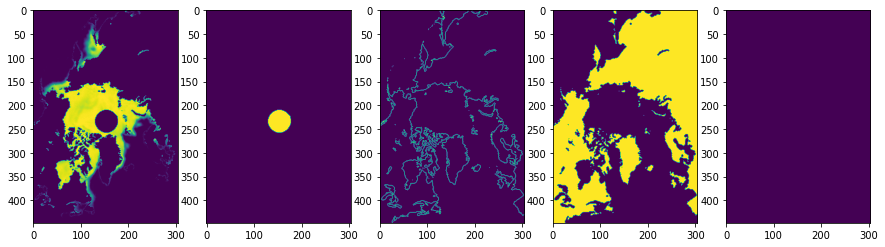

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(151)
plt.imshow(train[0,:,:,0])
plt.subplot(152)
plt.imshow(train[0,:,:,1])
plt.subplot(153)
plt.imshow(train[0,:,:,2])
plt.subplot(154)
plt.imshow(train[0,:,:,3])
plt.subplot(155)
plt.imshow(train[0,:,:,4])

In [ ]:
train_month = []
for i in range(12):
  train_month.append(train[i::12,:,:])
train_month = np.array(train_month)

train_month.shape

(12, 40, 448, 304, 5)

In [ ]:
stride = 32
temp = np.zeros([train_month.shape[0],
                 train_month.shape[1],
                 train_month.shape[2]+(stride-train_month.shape[2]%stride),
                 train_month.shape[3]+(stride-train_month.shape[3]%stride),
                 train_month.shape[4]], np.uint8)
temp[:,:,:train_month.shape[2],:train_month.shape[3],:] = train_month
train_month = temp
del temp


In [ ]:
train_month.shape

(12, 40, 480, 320, 5)

In [ ]:
window_size = 5

x_train = []
y_train = []

for i in range(train_month.shape[1]-window_size):
  x_train.append(train_month[:,i:i+window_size,:,:,:])
  y_train.append(train_month[:,i+window_size:i+window_size+1,:,:,:])

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape, y_train.shape

((35, 12, 5, 480, 320, 5), (35, 12, 1, 480, 320, 5))

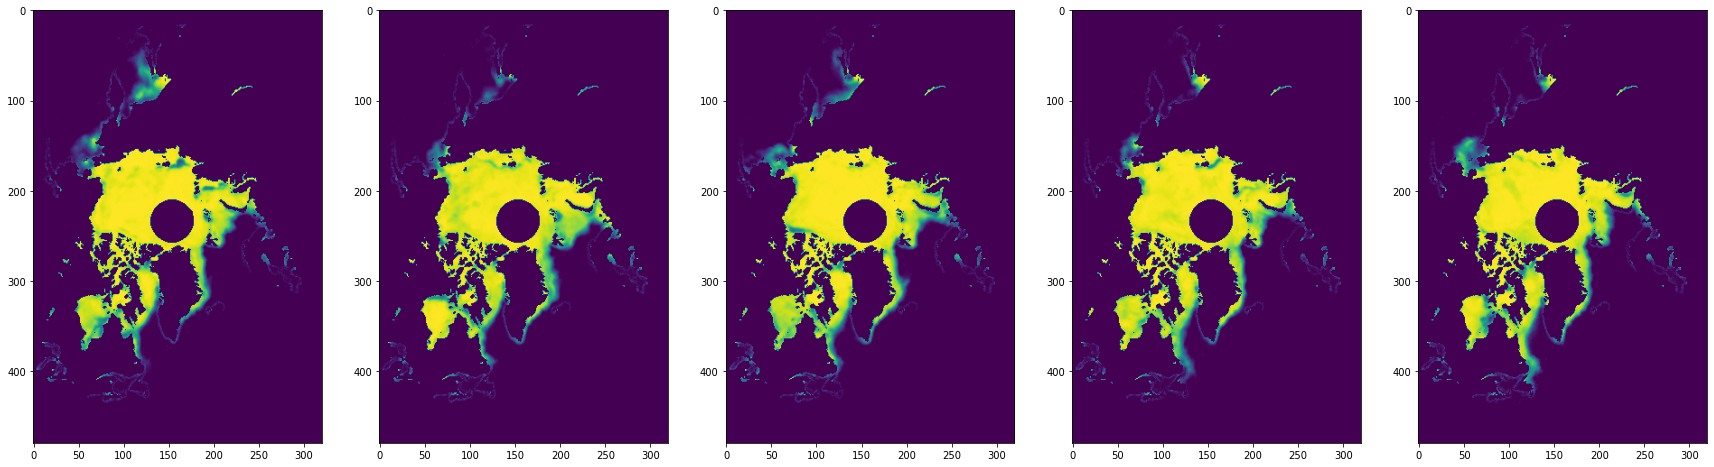

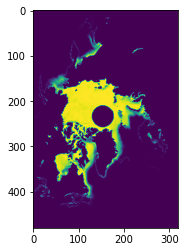

In [ ]:
m = 5
plt.figure(figsize=(30,25))
for y in range(x_train.shape[2]):
  plt.subplot(1,window_size,y+1)
  plt.imshow(x_train[0,m-1,y,:,:,0])
plt.show()

plt.imshow(y_train[0,m-1,-1,:,:,0])

In [ ]:
feature_size = 128
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
  for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
      for j in range((x_train.shape[4]-feature_size)//stride+1):
        x_ = x_train[y,m,:,stride*i:stride*i+feature_size, stride*j:stride*j+feature_size,:1]
        y_ = y_train[y,m,:,stride*i:stride*i+feature_size, stride*j:stride*j+feature_size,:1]
        x_train_.append(x_)
        y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for m in range(12):
  for i in range((x_train.shape[3]-feature_size)//stride+1):
    for j in range((x_train.shape[4]-feature_size)//stride+1):
      x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
      y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
      x_val_.append(x_)
      y_val_.append(y_)

x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

In [ ]:
x_train_.shape, y_train_.shape, x_val_.shape,y_val_.shape

((35280, 5, 128, 128, 1),
 (35280, 1, 128, 128, 1),
 (1008, 5, 128, 128, 1),
 (1008, 1, 128, 128, 1))

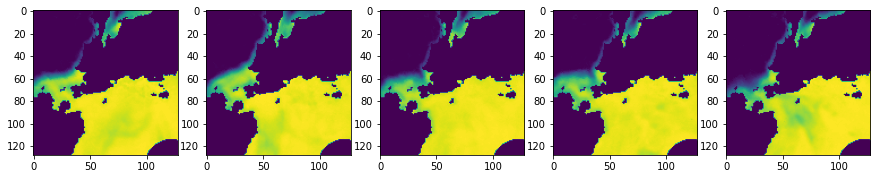

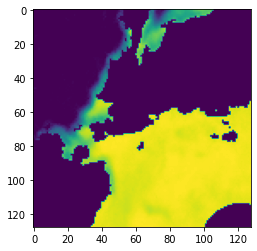

In [ ]:
i = 22
plt.figure(figsize=(15,10))
for y in range(x_train_.shape[1]):
  plt.subplot(1,window_size,y+1)
  plt.imshow(x_train_[i,y,:,:,0])
plt.show()
plt.imshow(y_train_[i,-1,:,:,0])

In [ ]:
def train_map_func(x,y):
  x = tf.cast(x, tf.float32)/250
  y = tf.cast(y, tf.float32)
  return x,y

In [ ]:
Batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_,y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(Batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_,y_val_))
val_dataset = val_dataset.map(train_map_func,num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(Batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

In [ ]:
with strategy.scope():
  inputs=Input((None,x_train_.shape[2],x_train_.shape[3],1))

  convLSTM=ConvLSTM2D(filters=64,kernel_size=3,padding='same',return_sequences=True)(inputs)
  convLSTM=BatchNormalization()(convLSTM)

  convLSTM=ConvLSTM2D(filters=64,kernel_size=3,padding='same',return_sequences=True)(convLSTM)
  convLSTM=BatchNormalization()(convLSTM)

  convLSTM=ConvLSTM2D(filters=64,kernel_size=3,padding='same',return_sequences=True)(convLSTM)
  convLSTM=BatchNormalization()(convLSTM)

  outputs = Conv3D(filters=1, kernel_size=3, activation='relu', padding='same', data_format='channels_last')(convLSTM)

  model = Model(inputs,outputs)
  model.compile(loss='mae',optimizer=Adam())

model.summary()

In [ ]:
if not (os.path.isdir('models')):
  os.makedirs('models')

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/convlstm_model.h5',
        monitor='val_loss',
        save_bset_only=True
     )
]

hist = model.fit(train_dataset, epochs=20, validation_data=val_dataset,callbacks=callbacks_list)

In [ ]:
plt.plot(hist.history['loss'][1:])
plt.plot(hist.history['val_loss'][1:])
plt.show()

In [ ]:
model = load_model('./models/convlstm_model.h5')

In [ ]:
pred = model.predict(next(iter(val_dataset))[0])
pred = np.where(pred>250, 250, pred)

In [ ]:
for i in range(Batch_size):
  plt.subplot(141)
  plt.imshow(next(iter(val_dataset))[1][i,0,:,:,0])
  plt.subplot(142)
  plt.imshow(pred[i,0,:,:,0])
  plt.show()
  print(np.mean(np.abs(next(iter(val_dataset))[1][i,0,:,:,0] - pred[i,0,:,:,0])))

In [ ]:
x_test = train_month[:,-1*window_size:,:,:,:1]
x_test = np.swapaxes(x_test,0,1)

x_test_ = []
for m in range(12):
  feature = []
  for i in range((x_train.shape[3]-feature_size)//stride+1):
    for j in range((x_train.shape[4]-feature_size)//stride+1):
      x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]/250
      feature.append(x_)
  feature = np.array(feature)
  x_test_.append(feature)
x_test_ = np.array(x_test_)
x_train.shape[-5],x_test.shape, x_test_.shape



In [ ]:
preds=[]
for m in tqdm(range(12)):
  pred = model.predict(x_test_[m])
  pred = np.where(pred>250,250,pred)
  preds.append(pred)

In [ ]:
voting_mask = np.zeros((x_train.shape[3],x_train.shape[4]))
ones = np.ones((feature_size,feature_size))

for i in range((x_train.shape[3]-feature_size)//stride+1):
  for j in range((x_train.shape[4]-feature_size)//stride+1):
    voting_mask[stride*i:stride*i+feature_size,stride*j:stride*j+feature_size] += ones

plt.imshow(voting_mask)
voting_mask.shape

In [ ]:
results=[]
for m in range(12):
  pred = np.zeros((x_train.shape[-3],x_train.shape[-2]))
  k=0
  for i in range((x_train.shape[3]-feature_size)//stride+1):
    for j in range((x_train.shape[4]-feature_size)//stride+1):
      pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
      k+=1
  pred /= voting_mask
  results.append(pred[:448,:304])
results=np.array(results)

In [ ]:
for m in range(12):
  plt.imshow(results[m])
  plt.show()
  print(m+1,'\n')

In [ ]:
submission = pd.read_csv(path+'sample_submission.csv')
submission

In [ ]:
sub_2019 = submission.loc[:11,['month']].copy()
sub_2020 = submission.loc[12:].copy()

sub_2019 = pd.concat([sub_2019, (pd.DataFrame(results.reshape([12,-1])))], axis = 1)
sub_2019.columns = submission.columns
submission = pd.concat([sub_2019, sub_2020])
submission

submission.to_csv('./submitssion_1.csv', index=False)
submission.to_csv('/content/drive/MyDrive/DACON/North_Pole/submitssion_2.csv', index=False)